# Monte Carlo Simulation for Portfolio Risk

This notebook aims to give readers an understanding of how Monte Carlo methods can be used to model portfolio risk in a probabilistic and forward-looking manner. Rather than relying on single-point estimates or static risk measures, Monte Carlo simulation allows us to generate a distribution of possible future portfolio outcomes based on historical return characteristics and explicit statistical assumptions.

By simulating thousands of potential price paths, we can quantify downside risk, tail behaviour, and path-dependent effects such as drawdowns, providing a more realistic picture of portfolio risk under both normal and stressed market conditions.

### Background

In financial markets, future returns are inherently uncertain and cannot be forecasted with certainty. Traditional risk metrics such as volatility or beta summarise risk using historical averages, but they fail to capture the full range of possible outcomes and the asymmetry often observed in real-world returns.

Monte Carlo simulation addresses this limitation by:
- Modelling asset returns as random variables drawn from an assumed distribution (e.g. multivariate normal or Student-t)
- Preserving empirical volatility and correlation structures across assets
- Generating many alternative future scenarios rather than a single forecast

This framework is particularly useful for portfolio risk analysis, as it allows us to:
- Incorporate cross-asset dependencies
- Examine tail risk and extreme outcomes
- Evaluate the likelihood of breaching loss thresholds
- Stress-test portfolios under adverse volatility and correlation regimes

---

### Sections of the notebook

1. **Data Preparation**
   - Load historical price data for multiple assets
   - Compute log returns
   - Estimate empirical means, volatilities, and the covariance matrix

2. **Monte Carlo Simulation Engine**
   - Generate uncorrelated random shocks
   - Apply Cholesky decomposition to introduce realistic cross-asset correlation
   - Simulate correlated daily return paths
   - Aggregate asset-level returns into portfolio-level returns using predefined weights

3. **Portfolio Value Path Construction**
   - Apply compounding to convert returns into portfolio value trajectories
   - Simulate thousands of portfolio paths over the chosen time horizon

4. **Risk Metrics and Analysis**
   - Compute Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR)
   - Analyse maximum drawdowns and loss distributions
   - Estimate the probability of breaching predefined loss thresholds

5. **Stress Testing and Scenario Analysis**
   - Shock volatility and correlation assumptions to mimic crisis regimes
   - Compare baseline and stressed portfolio risk profiles
   - Interpret changes in tail risk and downside exposure




**Import the libraries**

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import warnings
from datetime import datetime
from matplotlib.gridspec import GridSpec
from scipy.stats import norm
from pandas.errors import PerformanceWarning

warnings.simplefilter(action="ignore", category=PerformanceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### 1. **Data Preparation**

We will be loading our data for the following tickers: ```['BNS.TO', 'GOOGL', 'XOM', 'NIO', 'KO', 'PEP','ARCC','IBM','AGNC','LCID']``` from **YahooFinance**. For our period of analysis, we will be using data from **2022** to **2024**

**Parameter Initialisation**

In [2]:
# Stock Tickers and Date Range
tickers = ['BNS.TO', 'GOOGL', 'XOM', 'NIO', 'KO', 'PEP','ARCC','IBM','AGNC','LCID']
start_date = '2022-01-01'
end_date = '2024-12-31'

# Monte Carlo Simulation Parameters
num_simulation = 10000
num_trading_days = 252
initial_investment = 1000000

# Initialise the random seed
np.random.seed(42)

In [3]:
# Define a function to import the data from Yahoo Finance
def import_historical_data(ticker, start_date, end_date):
  """
  This function takes in a list of stock tickers and a date range,
  and returns a DataFrame containing the adjusted closing prices for each ticker
  over the specified date range.
  """
  historical_data = pd.DataFrame()
  data = yf.download(ticker, start=start_date, end=end_date)
  if historical_data.empty:
    # Set the index to the date column of our first data
    historical_data.index = data.index
  
  # New section to handle for NaN values
  # Fill Nan values with the previous day's closing price
  data['Close'] = data['Close'].ffill()
  # If there are still NaN values (e.g., at the start), fill them with the next day's closing price
  data['Close'] = data['Close'].bfill()
  historical_data[ticker] = data['Close']
  return historical_data

In [4]:
tickers_prices = import_historical_data(tickers, start_date, end_date)
tickers_prices.head()

[*********************100%***********************]  10 of 10 completed


,BNS.TO,GOOGL,XOM,NIO,KO,PEP,ARCC,IBM,AGNC,LCID
Date,,,,,,,,,,
2022-01-03,8.599370,14.355345,71.785881,143.904205,116.169731,52.627060,409.299988,33.470001,152.591614,55.125237
2022-01-04,8.660598,14.505668,71.785881,143.316635,117.860542,53.505650,394.100006,31.580000,152.812180,57.198715
2022-01-05,8.437956,14.293853,71.295967,136.741806,118.031342,53.949390,366.799988,29.879999,153.332626,57.910122
2022-01-06,8.460222,14.307517,72.101929,136.714508,115.571976,53.665401,382.200012,29.309999,153.367905,59.272205
2022-01-07,8.515882,14.498831,72.291573,135.989502,115.136497,53.541157,419.799988,29.299999,153.561935,59.758038


Estimate and compute the mean, volatility and covariance

In [5]:
pct_return = tickers_prices.pct_change().dropna() # Daily percentage return
volatility = pct_return.std() # Volatility
mean_return = pct_return.mean() # Mean return
cov_matrix = pct_return.cov() # Covariance matrix

Weighting the stocks in our portfolio. For now, we will be randomly generating our weights for each stock and holding it constant across the entire duration of analysis

In [6]:
weights = np.random.random(len(mean_return))
weights /= np.sum(weights) # Normalize the weights
assert(sum(weights) == 1)

### 2 and 3. **Monte Carlo Simulation Engine, Portfolio Value Path Construction**


We will generate uncorrelated random shocks and apply the Cholesky decomposition to introduce realistic cross-asset correlation. Simulate correlated daily return paths, and finally aggregating asset-level returns into portfolio-level returns using predefined weights

Finally, we will apply compounding to convert returns into portfolio value trajectories, and simulate the projection with thousands of portfolio paths over the chosen time horizon

In [7]:
def monte_carlo_simulation(num_simulation, num_trading_days, weights, mean_returns, cov_matrix, initial_investment):
  meanM = np.full(shape = (num_trading_days, len(weights)), fill_value = mean_returns)
  meanM = meanM.T
  
  portfolio_sims = np.full(shape=(num_trading_days, num_simulation), fill_value=0.0)
  
  for sim in range(num_simulation):
    Z = np.random.normal(size=(num_trading_days, len(weights)))
    L = np.linalg.cholesky(cov_matrix)
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,sim] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initial_investment
    
  return portfolio_sims


def visualise_simulation(portfolio_sims):
  plt.figure(figsize=(18, 8))
  plt.plot(portfolio_sims)
  plt.ylabel('Portfolio Value ($)')
  plt.xlabel('Days')
  plt.title('Monte carlo simulation of a stock portfolio')
  plt.show()

In [8]:
portfolio_simulations = monte_carlo_simulation(num_simulation, num_trading_days, weights, mean_return, cov_matrix, initial_investment)

Visualising our Monte-Carlo Simulation

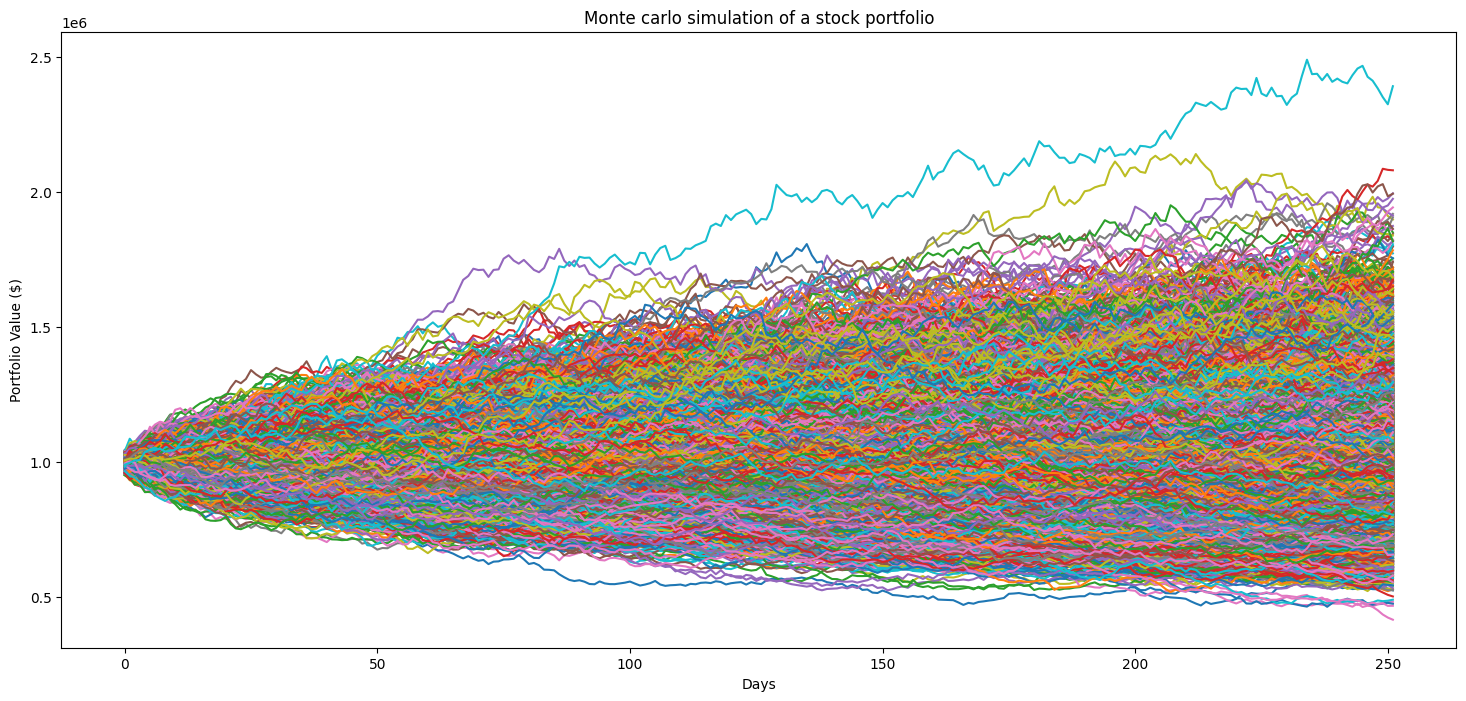

In [9]:
visualise_simulation(portfolio_simulations)

From our simulation, we can see that as we project our timeline further into the future, the dispersion of portfolio value paths increases markedly. This widening spread reflects the compounding nature of uncertainty: small variations in returns at earlier periods are amplified over time, leading to increasingly divergent outcomes across simulation paths.

One interesting observation from the simulation is that we can roughly define upper and lower bounds for the portfolio’s potential value at each future horizon. These bounds are not deterministic limits, but probabilistic envelopes derived from the distribution of simulated outcomes (for example, percentile bands). The upper bound represents optimistic but plausible scenarios driven by sustained positive return realizations, while the lower bound captures adverse scenarios in which negative shocks and drawdowns compound over time.

As the time horizon extends, these bounds move further apart, highlighting the trade-off between return potential and risk. While longer investment horizons increase the probability of achieving higher absolute returns, they also expose the portfolio to a wider range of unfavorable outcomes. This reinforces the importance of risk management measures such as diversification, position sizing, and drawdown control, particularly when making long-term allocation decisions.

### 4. **Risk Metrics and Analysis**

Now, we will compute Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR), and analyse maximum drawdowns and loss distributions. In addition we will also estimate the probability of breaching predefined loss thresholds

Visualization of Monte Carlo simulation is not very helpful in quantifying the risk, and as such we need to use additional parameters such as VaR and cVaR values to quantify unrealized and projected losses for the portfolio.

NOTE: VaR and cVaR are technically suppose to be negative in nature as they represent losses, but for reporting purposes, we will be keeping them as positive

In [10]:
def calculate_historical_var(losses, alpha):
  """ Input: pandas series of losses computed as (initial_investment - final simulated portfolio_value)
      Output: percentile on historical return distribution to a given confidence level alpha
  """
  if isinstance(losses, pd.Series):
    historical_var = np.percentile(losses, alpha)
    return -1 * historical_var # Multiply by -1 report losses as a positive value
  else:
    raise TypeError("Expected losses to be a pandas Series")
  
  
def calculate_parametric_var(losses, alpha):
  """ Input: pandas series of losses computed as (initial_investment - final simulated portfolio_value)
      Output: parametric VaR to a given confidence level alpha using mean and std dev
      
      Note that cVaR is the same as expected shortfall
  """
  if isinstance(losses, pd.Series):
    mean = losses.mean()
    std = losses.std()
    parametric_var = mean - std * norm.ppf(alpha / 100)
    return -1 * parametric_var # Multiply by -1 report losses as a positive value
  else:
    raise TypeError("Expected losses to be a pandas Series")
  
  
def calculate_cvar(losses, alpha, var_method='historical'):
  """ Input: pandas series of losses
      Output: CVaR or Expected Shortfall to a given confidence level alpha using historical or parametric VaR
  """
  if isinstance(losses, pd.Series):
    if var_method == 'historical':
      belowVaR = losses <= -1 * calculate_historical_var(losses, alpha)
    elif var_method == 'parametric':
      belowVaR = losses <= -1 * calculate_parametric_var(losses, alpha)
    cVaR = losses[belowVaR].mean()
    return -1 * cVaR # Multiply by -1 report losses as a positive value
  else:
    raise TypeError("Expected losses to be a pandas Series")
  

def var_cvar_portfolio(initial_investment, portfolio_sims, alpha, var_method='historical'):
  """ Input: 2D array of portfolio simulations, alpha confidence level, var_method
      Output: VaR and CVaR values for the portfolio at the given confidence level
      
      # Before passing in to VaR and CVaR functions, we need to compute the losses as:
      losses = (final simulated portfolio value) - (initial investment)
  """
  losses = pd.Series(portfolio_sims[-1, :]) - initial_investment
  if var_method == 'historical':
    var = calculate_historical_var(losses, alpha)
  elif var_method == 'parametric':
    var = calculate_parametric_var(losses, alpha)
  cvar = calculate_cvar(losses, alpha, var_method)
  print(f"Value at Risk (VaR) at {100-alpha}% confidence level: ${var:,.2f}")
  print(f"Conditional Value at Risk (CVaR) at {100-alpha}% confidence level: ${cvar:,.2f}")
  return var, cvar

Compute the 95% VaR and cVaR for our portfolio of assets. For that we will be using a value of 0.95 for our confidence level and the historical approach for our VaR and cVaR computation

In [11]:

confidence_level = 0.95
var_method = 'historical'
alpha = (1 - confidence_level) * 100
var_cvar_portfolio(initial_investment, portfolio_simulations, alpha, var_method)

Value at Risk (VaR) at 95.0% confidence level: $290,971.87
Conditional Value at Risk (CVaR) at 95.0% confidence level: $345,600.96


(290971.8740257485, 345600.95771822083)

Taking the output of one Monte-Carlo simulation:

```python
Value at Risk (VaR) at 95% confidence level: $351,801.80
Conditional Value at Risk (CVaR) at 95% confidence level: $410,648.28
```

Given an initial portfolio value of $1,000,000, the 95% VaR indicates that, over a horizon of 252 trading days, we are 95% confident that the portfolio will not incur losses greater than $351,801.80.
The 95% CVaR provides a more conservative risk measure by estimating the average loss conditional on outcomes worse than the 95% VaR threshold. 

In other words, if the portfolio performance falls into the worst 5% of simulated scenarios, the expected loss is approximately $410,648.28. Under such extreme scenarios, the portfolio value would be expected to decline to approximately: $1,000,000−$410,648.28=$589,351.72

Now, we will proceed to analyse our maximum drawdown and loss distributions

In [23]:
def analyse_drawdowns(portfolio_sim):
  """
  Compute the drawdown for each of our simulations and plot the worst drawdown.
  Ensure that the drawdown is calculated as (peak - trough) / peak and we will multiply by -1 to make it negative
  """
  drawdowns = pd.DataFrame()
  for i in range(portfolio_sim.shape[1]):
    peak = portfolio_sim[0,i]
    drawdown = []
    for value in portfolio_sim[:,i]:
      if value > peak:
        peak = value
      dd = (peak - value) / peak
      drawdown.append(-dd * 100) # Make drawdown negative and convert to percentage
    drawdowns[i] = drawdown
  
  worst_drawdown = drawdowns.min(axis=0)
  worst_simulation_index = worst_drawdown.idxmin()
  worst_drawdown = drawdowns[worst_simulation_index]
  print("Worst Drawdown across all simulations: {:.2f}%".format(worst_drawdown.min()))
  
  plt.figure(figsize=(21, 8))
  plt.plot(worst_drawdown, color='red')
  plt.title('Worst Drawdown Simulation')
  plt.ylabel('Drawdown (%)')
  plt.xlabel('Days')
  plt.show()
  
 
def drawdown_distribution(portfolio_sim):
  def max_drawdown(path):
    cumulative_max = np.maximum.accumulate(path)
    drawdowns = (path - cumulative_max) / cumulative_max
    return drawdowns.min()
  
  drawdowns = pd.Series([max_drawdown(portfolio_sim[:,i]) for i in range(portfolio_sim.shape[1])])
  print("Drawdown Distribution by Percentile [1%, 5%, 50%]:", np.percentile(drawdowns, [1, 5, 50]))
  
  plt.figure(figsize=(21, 6))
  plt.hist(drawdowns, bins=100, density=True, color='skyblue')
  plt.xlabel("Drawdown")
  plt.ylabel('Frequency')
  plt.legend()
  plt.title("Max Drawdown Distribution across Simulations")
  plt.show()
  
def analyse_loss_distribution(portfolio_sim, initial_investment, VaR_95, CVaR_95):
  """
  Analyze the distribution of losses at the end of the simulation period.
  """
  final_values = pd.Series(portfolio_sim[-1,:])
  losses = initial_investment - final_values # positive values indicate actual losses
  
  plt.figure(figsize=(21, 6))
  plt.hist(losses, bins=50, color='blue', alpha=0.7)
  plt.title('Distribution of Losses at End of Simulation')
  plt.axvline(-VaR_95, linestyle='--', label='VaR 95%')
  plt.axvline(-CVaR_95, linestyle=':', label='CVaR 95%')
  plt.legend()
  plt.xlabel("Loss Amount ($'000,000)")
  plt.ylabel('Frequency')
  plt.show()
  
  mean_loss = losses.mean()
  median_loss = losses.median()
  print("VaR(5%): ${:,.2f}".format(VaR_95))
  print("CVaR(5%): ${:,.2f}".format(CVaR_95))
  print(f"Mean Loss: ${abs(mean_loss):,.2f}") # abs to show positive loss value
  print(f"Median Loss: ${abs(median_loss):,.2f}") # abs to show positive loss value
  
  
def plot_var_and_cvar_line_on_mc_simulation(portfolio_sim, VaR_95, CVaR_95):
  """
  Plot the Monte Carlo simulation results with VaR and CVaR lines.
  """
  plt.figure(figsize=(18, 8))
  plt.plot(portfolio_sim, color='lightgray', alpha=0.5)
  plt.axhline(initial_investment - VaR_95, color='red', linestyle='--', label='VaR 95%')
  plt.axhline(initial_investment - CVaR_95, color='blue', linestyle=':', label='CVaR 95%')
  plt.title('Monte Carlo Simulation with VaR and CVaR Lines')
  plt.ylabel('Portfolio Value ($)')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

Worst Drawdown across all simulations: -60.42%


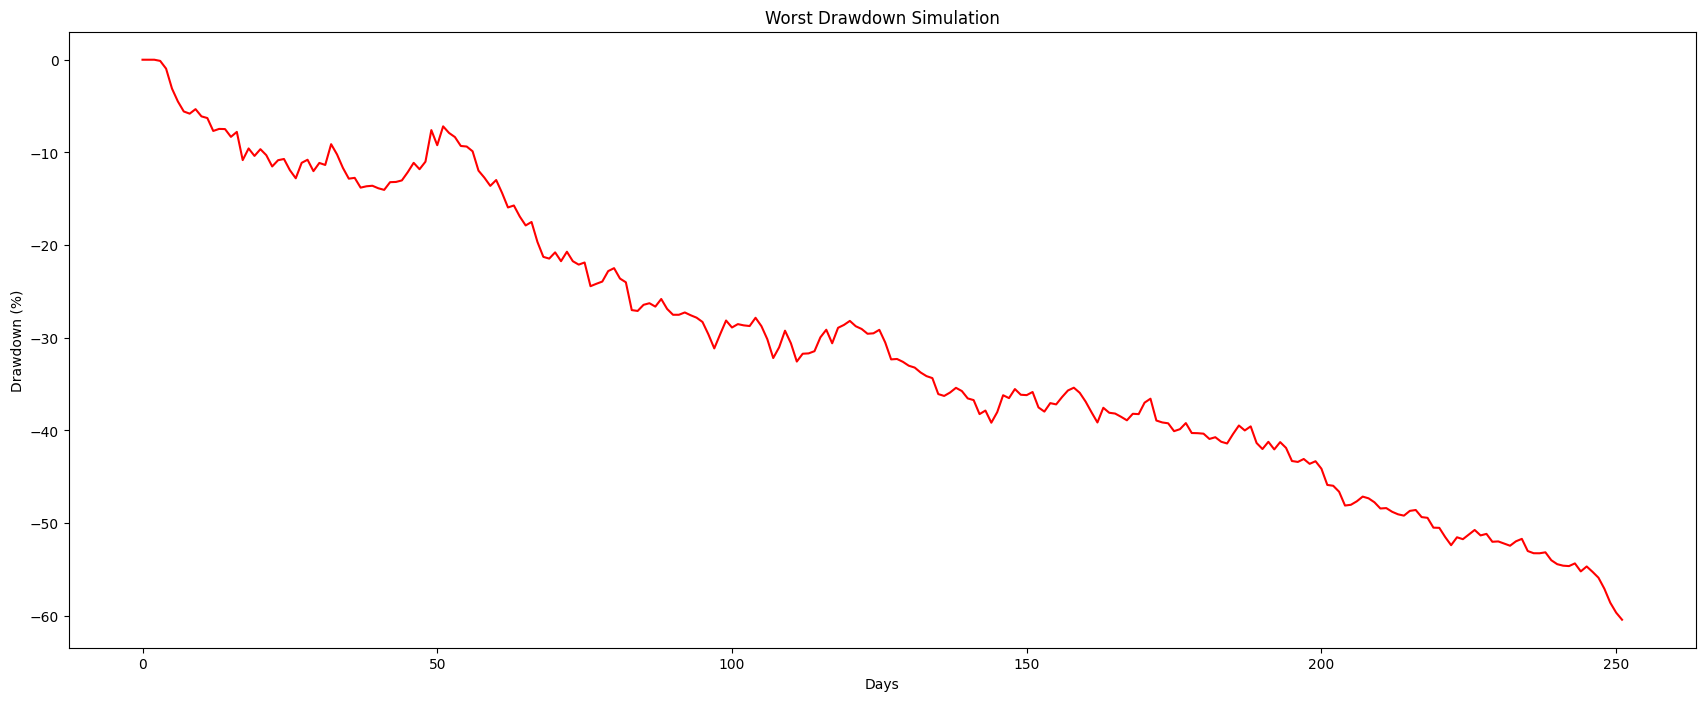

In [13]:
analyse_drawdowns(portfolio_simulations)

Value at Risk (VaR) at 95.0% confidence level: $290,971.87
Conditional Value at Risk (CVaR) at 95.0% confidence level: $345,600.96
Drawdown Distribution by Percentile [1%, 5%, 50%]: [-0.43002068 -0.36341294 -0.20186256]


/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_1795/3333132740.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


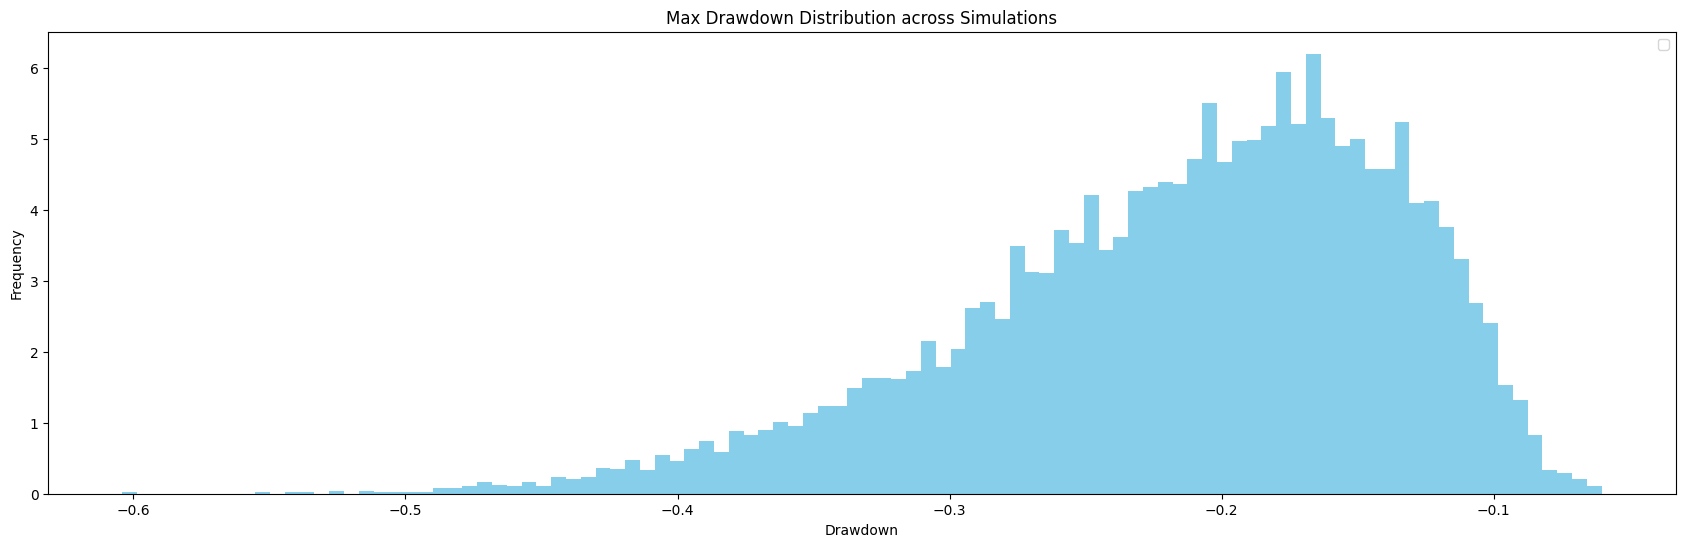

In [24]:
var, cvar = var_cvar_portfolio(initial_investment, portfolio_simulations, alpha, var_method)
drawdown_distribution(portfolio_simulations)

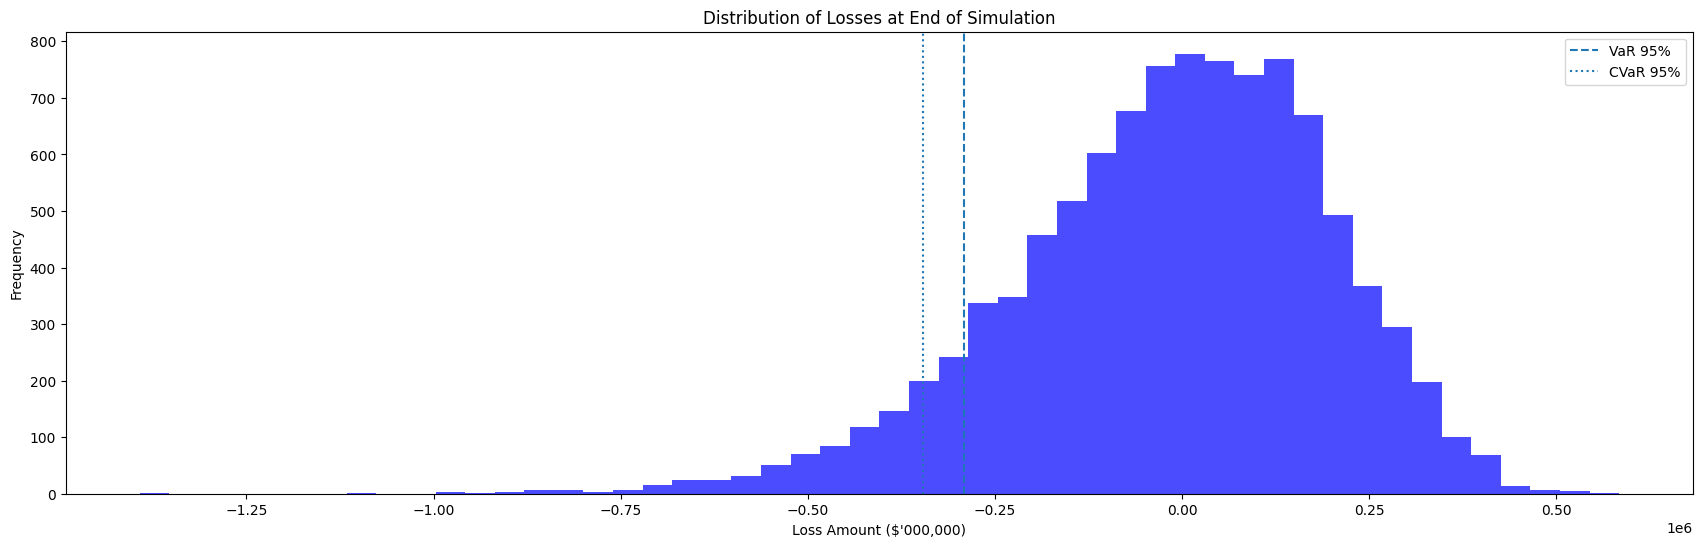

VaR(5%): $290,971.87
CVaR(5%): $345,600.96
Mean Loss: $15,478.85
Median Loss: $4,330.22


In [25]:
analyse_loss_distribution(portfolio_simulations, initial_investment, var, cvar)

Remarks (Again the values may change depending on your MC simulation):

---

That being said, given the following values from one simulation:

``` python
VaR(5%): $296,981.38
CVaR(5%): $355,329.25
Mean Loss: $13,896.64
Median Loss: $4,392.81
```

The 5% Value at Risk (VaR) of $296,981.38 indicates that, over a one-year horizon, 95% of simulated outcomes resulted in losses less than approximately 29.7% of the initial portfolio value of $1,000,000.

The 5% Conditional Value at Risk (CVaR) of $355,329.25 represents the average loss conditional on losses exceeding the VaR threshold. This highlights the severity of tail risk: when losses are extreme, they tend to be materially larger than the VaR cutoff.

The gap between VaR and CVaR (~$58,000) suggests a fat-tailed loss distribution, where adverse outcomes deteriorate quickly beyond the 5% threshold.

The mean loss ($13,896.64) and median loss ($4,392.81) are both small relative to the portfolio size, implying that most simulated outcomes cluster around modest losses or near breakeven, with downside risk concentrated in relatively rare but severe events.

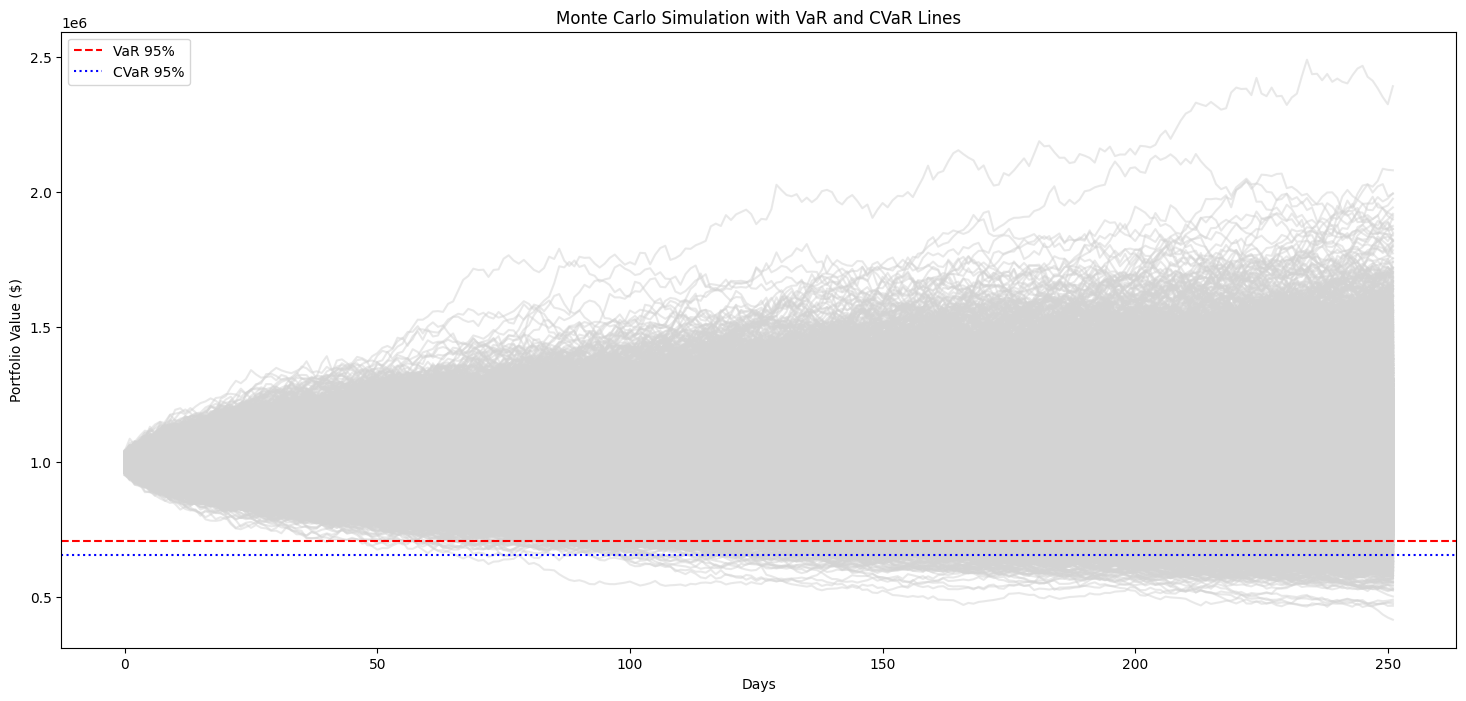

In [ ]:
plot_var_and_cvar_line_on_mc_simulation(portfolio_simulations, var, cvar)

### 5. **Stress Testing and Scenario Analysis**

Stress testing provides a structured framework for assessing portfolio resilience under extreme but plausible market conditions. Unlike traditional risk measures such as Value-at-Risk (VaR), which are designed to capture losses under typical market fluctuations, stress testing explicitly focuses on low-probability, high-impact events that may materially impair portfolio performance. By examining portfolio behaviour outside normal market regimes, stress testing helps identify vulnerabilities that may not be visible through standard risk metrics alone.

In this section, we develop a set of tools to construct and analyse stress scenarios using Python. We explore three complementary approaches: replicating historically observed crisis events, designing hypothetical “what-if” scenarios based on adverse market assumptions, and generating a broad distribution of outcomes through Monte Carlo simulations (which we have done above). Together, these methods provide multiple perspectives on tail risk and enhance our understanding of how portfolios may respond under severe market stress.

In summary, we aim to:
- Implement shock volatility and correlation assumptions to mimic crisis regimes
- Compare baseline and stressed portfolio risk profiles
- Interpret changes in tail risk and downside exposure

We will first define three functions:
- **historical scenarios**: To define the historical attributes and realised market shocks exhibited by a given asset during past stress events.
- **hypothetical scenarios**: To define custom, forward-looking shocks to specific assets or risk factors as part of targeted “what-if” modelling exercises.
- **Monte-Carlo ssenario**: To define a stochastic framework that generates a large distribution of potential portfolio outcomes by simulating correlated random paths for underlying assets, allowing us to assess tail behaviour and risk dispersion under uncertainty.

In [125]:
def historical_scenario(ticker, start_date, end_date):
  """
  This function fetches historical data for a given ticker symbol, calculates daily returns 
  and identifies the worst day return and the worst return over a 250-day period (approximately one trading year).
  
  It packages these into a dictionary, making it easy to use in our stress testing framework.
  """
  data = yf.download(ticker, start=start_date, end=end_date)
  returns = data['Close'].pct_change().dropna()
  
  # Worst 250-day period in historical data
  worst_period = returns[ticker].nsmallest(250).iloc[-1]
  scenario = {
    'type': 'historical', 
    'ticker': ticker,
    'returns': returns, 
    'worst_day': returns.min(), 
    'worst_250d': worst_period
  }
  return scenario


def hypothetical_scenario(assets, shocks):
  """
  assets: Dictionary of asset weights
          For example {'AAPL': 0.5, 'MSFT': 0.5} represents a portfolio with 50% AAPL and 50% MSFT.
  shocks: Dictionary of hypothetical shocks in percentage terms for each asset. 
          For example {'AAPL': -0.1, 'MSFT': -0.2} represents a 10% drop in AAPL and 20% drop in MSFT.
  """
  scenario = {
    'type': 'hypothetical', 
    'assets': assets,
    'shocks': shocks
  }
  return scenario


# We will modify the above Monte-Carlo simulation to fit the stress testing / scenario analysis section
def monte_carlo_scenario(initial_investment, weights, num_trading_days, num_simulations, risk_factors, covariance_matrix, means, distribution='normal'):
  """
  This function generates multiple scenarios by drawing random samples from specified probability distributions.
  """
  num_of_assets = len(weights)
  
  # Generate random samples based on the specified distribution
  # Distribution Option 1: Normal Distribution
  if distribution == 'normal':
    """
    This method is the same as the monte_carlo_simulation_returns function but adapted to return the simulated returns for each scenario.
    """
    meanM = np.full(shape = (num_trading_days, num_of_assets), fill_value = means)
    meanM = meanM.T
    portfolio_sims = np.full(shape=(num_trading_days, num_simulations), fill_value=0.0)
    
    for sim in range(num_simulations):
      Z = np.random.normal(size=(num_trading_days, num_of_assets))
      L = np.linalg.cholesky(covariance_matrix)
      dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
      portfolio_sims[:,sim] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initial_investment
    
    # Compute the returns from the portfolio simulations given the initial investment
    simulated_returns = (portfolio_sims - initial_investment) / initial_investment
    simulated_returns = simulated_returns.T  # Transpose to shape (num_simulations, num_of_assets)
    
  # Distribution Option 2: Multivariate t-Distribution
  elif distribution == 't':
    df = 5  # degrees of freedom for t-distribution
    g = df / (df - 2)  # Scaling factor for t-distribution to match covariance
    # 1. Generate independent t-distributed draws
    z = np.random.standard_t(df, size=(num_simulations, num_of_assets))  # shape (num_simulations, num_assets)
    # 2. Scale for covariance
    L = np.linalg.cholesky(covariance_matrix)  # shape (num_assets, num_assets)
    # 3. Simulated correlated t-returns
    simulated_returns = (z / np.sqrt(g)) @ L.T
    simulated_returns += means.values
    
  # Distribution Option 3: Uniform Distribution
  elif distribution == 'uniform':
    simulated_returns = np.random.uniform(low=-0.1, high=0.1, size=(num_simulations, num_of_assets))  
  
  # Unsupported Distribution
  else:
    raise ValueError("Unsupported distribution type")
  
  scenarios = []
  for i in range(num_simulations):
    scenario = {
      'type': 'monte_carlo', 
      'changes': dict(zip(risk_factors, simulated_returns[i, :]))
    }
    scenarios.append(scenario)
  return scenarios
    

Unlike the previous section, we will need to define classes to manage our collection of assets, as well as classes for each asset type, including attributes relevant to stress testing

In [35]:
class Stock:
  def __init__(self, ticker, shares, current_price=None, volatility=None):
    self.ticker = ticker
    self.shares = shares
    self.current_price = current_price
    self.volatility = volatility  # Can be estimated or fetched.

    if current_price is None:
      try:  # To fetch current price data
        data = yf.download(ticker, period="1d")
        self.current_price = data['Close'][ticker][0]
      except Exception as e:
        print(f"Could not fetch current price for {ticker}: {e}")
        self.current_price = 0  # Set to 0 if fetching fails

  def get_value(self):
    return self.shares * self.current_price
  
  def get_ticker(self):
    return self.ticker


class Bond:
  def __init__(self, name, maturity_date, coupon_rate, face_value, yield_to_maturity):
    self.name = name  # Add a name attribute for bonds
    self.maturity_date = maturity_date
    self.coupon_rate = coupon_rate
    self.face_value = face_value
    self.yield_to_maturity = yield_to_maturity

  def get_value(self):  # Simplified bond valuation
    return self.face_value / (1 + self.yield_to_maturity)


class Option:
  def __init__(self, underlying_asset, strike_price, expiration_date, option_type):
    self.underlying_asset = underlying_asset
    self.strike_price = strike_price
    self.expiration_date = expiration_date
    self.option_type = option_type  # "call" or "put"
    self.value = None  # Option value will depend on pricing model

  def get_value(self):
    return self.value


class Portfolio:
  def __init__(self):
    self.assets = []
  
  def add_asset(self, asset):
    self.assets.append(asset)
    
  def get_total_value(self):
    total_value = 0
    for asset in self.assets:
      total_value += asset.get_value()
    return total_value

  def get_asset_allocation(self):
    allocation = {}
    total_value = self.get_total_value()
    for asset in self.assets:
      if isinstance(asset, Stock):  # Asset is a Stock
        allocation[asset.ticker] = asset.get_value() / total_value
      elif isinstance(asset, Bond):  # Asset is a Bond
        allocation[asset.name] = asset.get_value() / total_value  # Use bond name in allocation

    return allocation

With that, we will utilise our functions from above and co-integrate it with the assets defined in the start of this notebook

Our start date, end date and initial investments will all be retrieved from the initialised variables at the start of the notebook.

In [36]:
try:
  stock_data = yf.download(tickers, start=start_date, end=end_date)  # Download data until present
except Exception as e:  # Handle possible errors during download
  print(f"Error downloading data: {e}")

[*********************100%***********************]  10 of 10 completed


In [37]:
portfolio = Portfolio()

# For now, we will just randomly assign shares to each stock in our basket
share_count = [np.random.randint(200, 500) for _ in tickers] # Random share count between 200 and 500

for ticker, shares in zip(tickers, share_count):
  print(f"Adding {shares} shares of {ticker} to portfolio.")
  portfolio.add_asset(Stock(ticker, shares))

[*********************100%***********************]  1 of 1 completed

Adding 312 shares of BNS.TO to portfolio.
Adding 473 shares of GOOGL to portfolio.



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Adding 328 shares of XOM to portfolio.
Adding 222 shares of NIO to portfolio.
Adding 269 shares of KO to portfolio.



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Adding 423 shares of PEP to portfolio.
Adding 428 shares of ARCC to portfolio.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Adding 283 shares of IBM to portfolio.
Adding 244 shares of AGNC to portfolio.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Adding 301 shares of LCID to portfolio.


In [38]:
def portfolio_composition(portfolio):
  # Calculate and print portfolio value and allocation.
  total_portfolio_value = portfolio.get_total_value()
  print(f"Total Portfolio Value: ${total_portfolio_value:.2f}")
  asset_allocation = portfolio.get_asset_allocation()
  print(f"Asset Allocation:\n{asset_allocation}")

  asset_names = list(asset_allocation.keys())
  allocation_percentages = list(asset_allocation.values())

  # Plot a bar chart of asset allocation
  plt.figure(figsize=(18, 5))
  plt.bar(asset_names, allocation_percentages)
  plt.xlabel('Assets')
  plt.ylabel('Allocation Percentage')
  plt.title('Portfolio Asset Allocation - Bar Chart')
  plt.show()

Total Portfolio Value: $425590.27
Asset Allocation:
{'BNS.TO': 0.07462952737149692, 'GOOGL': 0.3756523821631741, 'XOM': 0.1089761700513143, 'NIO': 0.002451653675036307, 'KO': 0.04728465522964571, 'PEP': 0.1526949654129171, 'ARCC': 0.02000261818077161, 'IBM': 0.2039428739206999, 'AGNC': 0.006535863437831556, 'LCID': 0.007829290557112505}


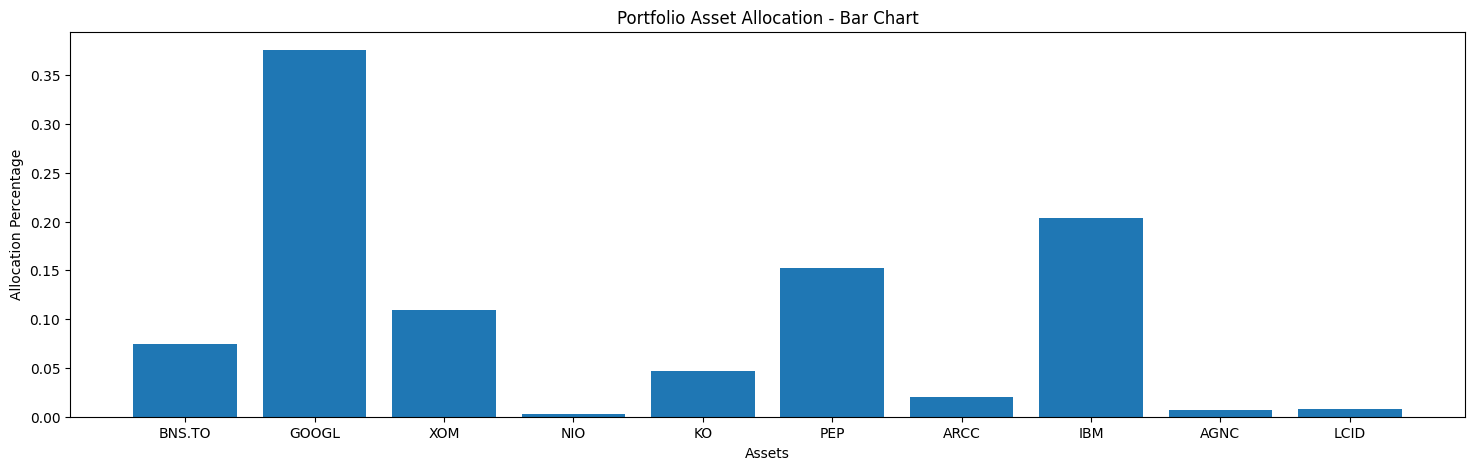

In [39]:
portfolio_composition(portfolio)

We can define a function for our sensitivity analysis

In [42]:
def sensitivity_analysis(portfolio, risk_factors, shock_range):
  """
  This function performs sensitivity analysis by shocking a specific risk factor and observing the impact on portfolio value.
  
  It takes the portfolio, a specific risk factor and a range of shocks as input. 
  It then calculates the portfolio value under each shock, providing valuable insights into the portfolio's sensitivity to that factor.
  """
  results = []
  for shock in shock_range:
    shocked_portfolio_value = 0
    for asset in portfolio.assets:
      if isinstance(asset, Stock) and asset.ticker in risk_factors: # Check for Stock instance and matching ticker
        shocked_price = asset.current_price * (1 + shock) # Shock is a decimal (e.g., 0.1 for 10%)
        shocked_portfolio_value += asset.shares * shocked_price
      elif isinstance(asset, Bond) and asset.name in risk_factors: # Check for Bond instance and matching name
        # Example: Bond sensitivity to yield changes. Adapt if needed.
        shocked_yield = asset.yield_to_maturity + shock
        shocked_value = asset.face_value / (1+shocked_yield)
        shocked_portfolio_value += shocked_value
      else:
        shocked_portfolio_value += asset.get_value()
    results.append(shocked_portfolio_value)
  
  return shock_range, results


def portfolio_sensitivity_to_shock_visualisation(portfolio,risk_factors, shock_range):
  """
  Risk factor refers to the specific assets or factors being shocked. E.g GOOGL or TSLA etc...
  Shock range is a range of shock percentages to apply to the risk factor(s).
  This function visualizes the portfolio sensitivity to shocks in across specific risk factors.
  """
  # Perform sensitivity analysis for all our risk factors
  plt.figure(figsize=(18, 6))
  for risk_factor in risk_factors:
    shocks, portfolio_values = sensitivity_analysis(portfolio, risk_factor, shock_range)
    plt.plot(shocks, portfolio_values, marker='.', label=', '.join(risk_factor))
  plt.title(f'Portfolio Sensitivity to Risk Factor Shocks')
  plt.legend()
  plt.xlabel('Shock (%)')
  plt.ylabel('Portfolio Value ($)')
  plt.grid()
  plt.show()

Let us visualise the portfolio sensitivity to shock with some examples

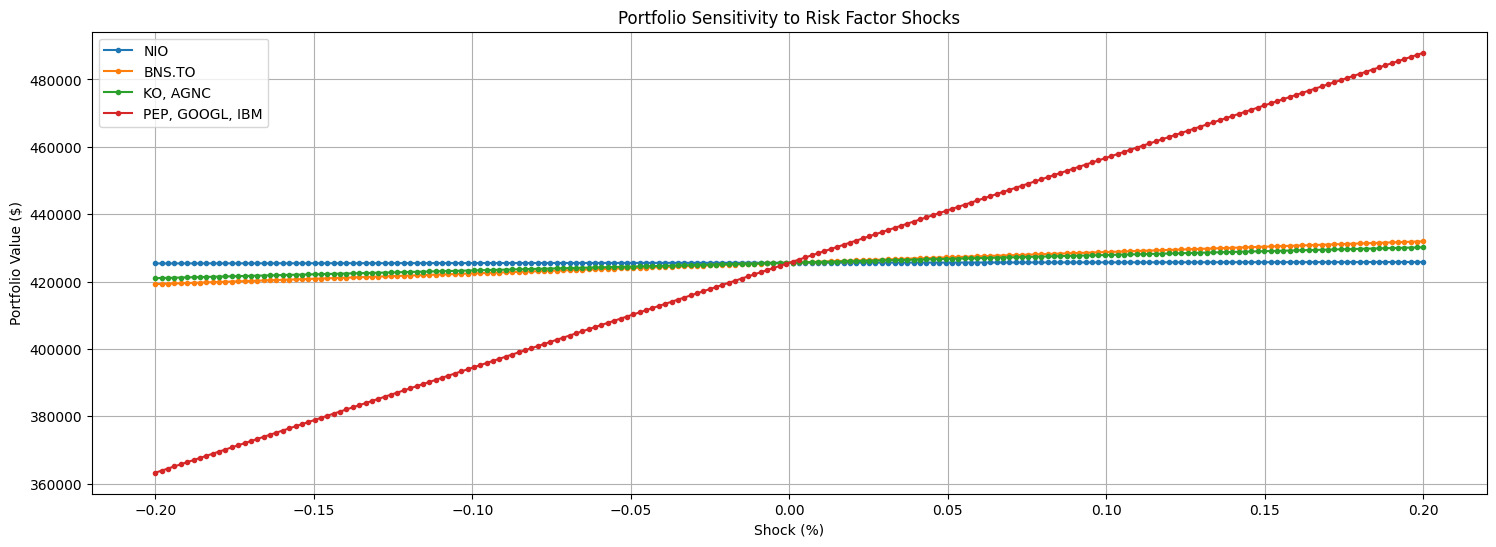

In [43]:
alpha = 0.05
risk_factor = [['NIO'], ['BNS.TO'], ['KO', 'AGNC'], ['PEP', 'GOOGL', 'IBM']]
shock_range = np.linspace(-0.2, 0.2, 200)  # -20% to +20%
portfolio_sensitivity_to_shock_visualisation(portfolio, risk_factor, shock_range)

Now, we will create a function to simulate portfolio performance under stress

In [139]:
from matplotlib.gridspec import GridSpec


def backtest_portfolio(portfolio, scenario):
  """
  This function backtests the portfolio against a given scenario.
  It adjusts the asset values based on the scenario's shocks or historical returns,
  and calculates the portfolio value after applying the scenario.
  """
  portfolio_value = portfolio.get_total_value()
  
  if scenario['type'] == 'historical':
    returns = scenario['returns']
    
    # Example: Apply historical returns to the risk factor specified in the scenario
    shocked_portfolio_value = 0
    for asset in portfolio.assets:
      if isinstance(asset, Stock) and asset.ticker == scenario['ticker']:
        # Use the last return from the historical scenario
        shocked_value = asset.get_value() * (1 + returns.iloc[-1])
        shocked_portfolio_value += shocked_value
      else:
        shocked_portfolio_value += asset.get_value()
    portfolio_return = (shocked_portfolio_value - portfolio_value) / portfolio_value
  
  elif scenario['type'] == 'hypothetical':
    shocked_portfolio_value = 0
    for asset in portfolio.assets:
      if isinstance(asset, Stock) and asset.ticker in scenario['shocks']:
        shocked_price = asset.current_price * (1 + scenario['shocks'][asset.ticker])
        shocked_portfolio_value += shocked_price * asset.shares
      else:
        shocked_portfolio_value += asset.get_value()
    portfolio_return = (shocked_portfolio_value / portfolio_value) - 1
  
  elif scenario['type'] == 'monte_carlo':
    shocked_portfolio_value = 0
    for asset in portfolio.assets:
      if isinstance(asset, Stock) and asset.ticker in scenario['changes']:
        shocked_price = asset.current_price * (1 + scenario['changes'][asset.ticker])
        shocked_portfolio_value += shocked_price * asset.shares
      else:
        shocked_portfolio_value += asset.get_value()
    portfolio_return = (shocked_portfolio_value - portfolio_value) / portfolio_value
  
  return portfolio_return


def generate_scenario(scenario_type, **kwargs):
  if scenario_type == 'historical':
    return historical_scenario(**kwargs)
  elif scenario_type == 'hypothetical':
    return hypothetical_scenario(**kwargs)
  elif scenario_type == 'monte_carlo':
    return monte_carlo_scenario(**kwargs)
  else:
    raise ValueError("Unsupported scenario type")


def backtesting_visualisation(initial_investment, num_trading_days, num_simulations, shock_factor, \
  risk_factors, asset_weights, shocks, start_date, end_date, covariance_matrix, means, distribution):
  # Historical Scenario
  hist_scenario = generate_scenario(
    'historical', 
    ticker=shock_factor, 
    start_date=start_date, 
    end_date=end_date
  )
  # Hypothetical Scenario
  hypo_scenario = generate_scenario(
    'hypothetical', 
    assets=asset_weights, 
    shocks=shocks
  )
  # Monte Carlo Scenario
  mc_scenarios = generate_scenario(
    'monte_carlo', 
    initial_investment=initial_investment, 
    weights=np.array(list(asset_weights.values())),
    num_trading_days=num_trading_days, 
    num_simulations=num_simulations, 
    risk_factors=risk_factors, 
    covariance_matrix=covariance_matrix, 
    means=means,
    distribution=distribution
  )
  
  portfolio_returns_hist = [backtest_portfolio(portfolio, hist_scenario) for _ in range(num_trading_days)]  # example number of points, using same scenario
  portfolio_returns_hypo = backtest_portfolio(portfolio, hypo_scenario)
  portfolio_returns_mc = [backtest_portfolio(portfolio, s) for s in mc_scenarios]
  
  shock_factor_changes = [scenario['changes'][shock_factor] for scenario in mc_scenarios]
  portfolio_returns_hist_val = [s.iloc[0] for s in portfolio_returns_hist]
 
  # Visualization
  fig = plt.figure(figsize=(14, 8))
  gs = GridSpec(4, 4)

  # Plot 1: Joint scatter plot with marginal histograms
  ax_joint = fig.add_subplot(gs[1:4, 0:3])
  ax_joint.scatter(shock_factor_changes, portfolio_returns_mc)
  ax_joint.set_xlabel(f'{risk_factors} Change')
  ax_joint.set_ylabel('Portfolio Return')
  ax_joint.set_title(f'Portfolio Returns vs {risk_factors} Changes (Monte Carlo) with {distribution} distribution')

  # Marginal histogram (top: shock factor changes)
  ax_marg_x = fig.add_subplot(gs[0, 0:3])
  ax_marg_x.hist(shock_factor_changes, bins=50)
  ax_marg_x.set_ylabel('Frequency')

  # Marginal histogram (right: portfolio returns, vertical)
  ax_marg_y = fig.add_subplot(gs[1:4, 3])
  ax_marg_y.hist(portfolio_returns_mc, bins=50, orientation='horizontal')
  ax_marg_y.set_xlabel('Frequency')
  plt.setp(ax_marg_x.get_xticklabels(), visible=False)
  plt.setp(ax_marg_y.get_yticklabels(), visible=False)
  plt.tight_layout()
  plt.show()
  
  # Plot 2: Boxplot comparison between Historical and Monte Carlo
  plt.figure(figsize=(10, 6))
  plt.boxplot([portfolio_returns_hist_val, portfolio_returns_mc], labels=['Historical', 'Monte Carlo'])
  plt.title(f'Portfolio Returns: Historical vs. Monte Carlo ({distribution} distribution)')
  plt.ylabel('Portfolio Return')
  plt.show()
  
  print(f"Portfolio Return (Historical): {portfolio_returns_hist_val[0]:.4f}")
  print(f"Portfolio Return (Hypothetical): {portfolio_returns_hypo:.4f}")
  print(f"Average Portfolio Return (Monte Carlo) ({distribution} distribution): {np.mean(portfolio_returns_mc):.4f}")


Initialise our parameters for **stress testing**

In [140]:
num_of_simulations = 100000
shock_factor = 'IBM'
distribution = 'normal'  # Options: 'normal', 't', 'uniform'
asset_weights = portfolio.get_asset_allocation() # use the allocation from our portfolio
shocks = {asset: np.random.uniform(-0.3, 0) for asset in asset_weights} # Randomise the shocks for each asset in the portfolio
risk_factors = ['IBM', 'GOOGL', 'NIO']  # Example risk factors
covariance_matrix = cov_matrix # Defined and computed earlier in the script
means = mean_return # Defined and computed earlier in the script
initial_investment = portfolio.get_total_value()
num_trading_days = 252

[*********************100%***********************]  1 of 1 completed


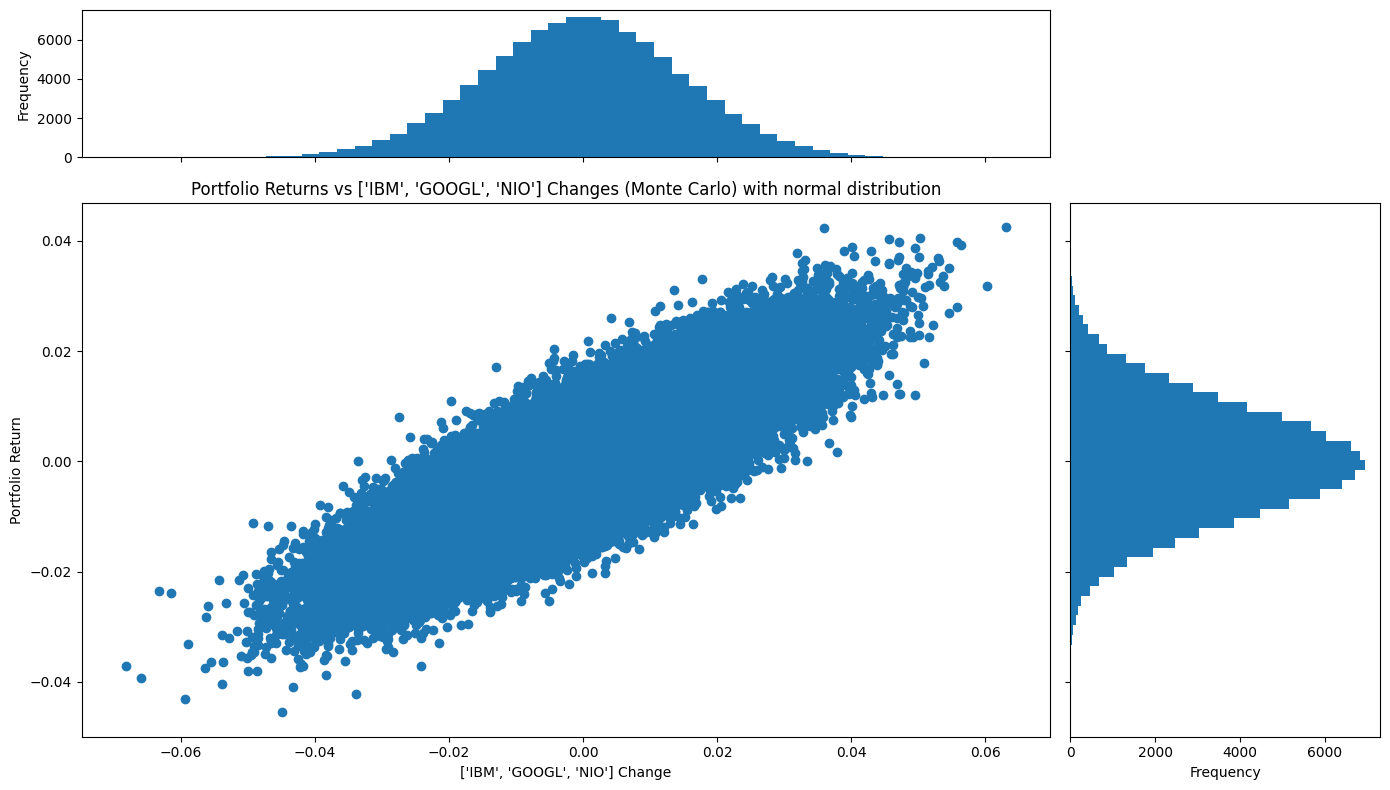

/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_1795/2508954890.py:122: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([portfolio_returns_hist_val, portfolio_returns_mc], labels=['Historical', 'Monte Carlo'])


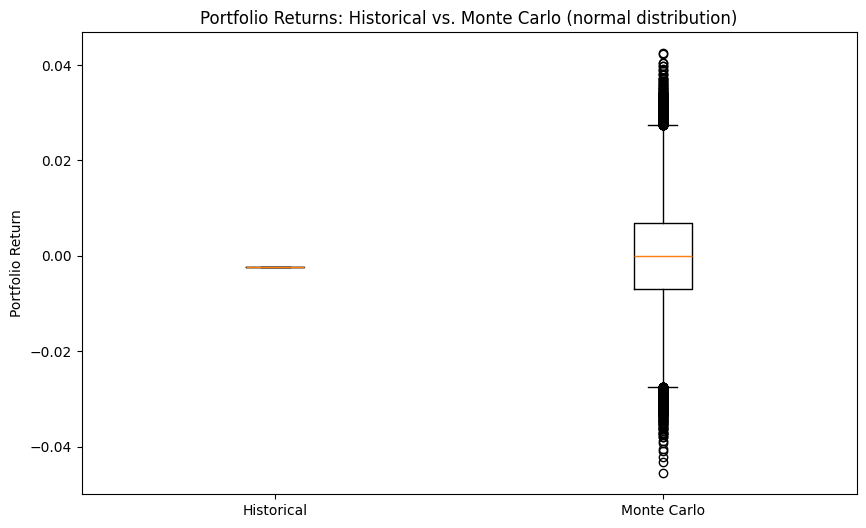

Portfolio Return (Historical): -0.0023
Portfolio Return (Hypothetical): -0.1375
Average Portfolio Return (Monte Carlo) (normal distribution): -0.0000


In [141]:
backtesting_visualisation(initial_investment, num_trading_days, num_of_simulations, shock_factor, \
  risk_factors, asset_weights, shocks, start_date, end_date, covariance_matrix, means, distribution)